# Taiwan COVID-19 data visualization

In [19]:
# Download specimen data and back up previous data
!mv covid19_tw_specimen.csv covid19_tw_specimen_backup_$(date '+%y%m%d').csv
!wget https://od.cdc.gov.tw/eic/covid19/covid19_tw_specimen.csv

# Download day_confirmation data and back up previous data
!mv Day_Confirmation_Age_County_Gender_19CoV.csv Day_Confirmation_Age_County_Gender_19CoV_backup_$(date '+%y%m%d').csv
!wget https://od.cdc.gov.tw/eic/Day_Confirmation_Age_County_Gender_19CoV.csv

--2021-06-12 17:16:29--  https://od.cdc.gov.tw/eic/covid19/covid19_tw_specimen.csv
Resolving od.cdc.gov.tw (od.cdc.gov.tw)... 35.229.205.172
Connecting to od.cdc.gov.tw (od.cdc.gov.tw)|35.229.205.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16208 (16K) [text/csv]
Saving to: ‘covid19_tw_specimen.csv’

covid19_tw_specimen 100%[===================>]  15.83K  --.-KB/s    in 0.002s  

2021-06-12 17:16:30 (6.21 MB/s) - ‘covid19_tw_specimen.csv’ saved [16208/16208]

--2021-06-12 17:16:30--  https://od.cdc.gov.tw/eic/Day_Confirmation_Age_County_Gender_19CoV.csv
Resolving od.cdc.gov.tw (od.cdc.gov.tw)... 35.229.205.172
Connecting to od.cdc.gov.tw (od.cdc.gov.tw)|35.229.205.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611172 (597K) [text/csv]
Saving to: ‘Day_Confirmation_Age_County_Gender_19CoV.csv’

Day_Confirmation_Ag 100%[===================>] 596.85K  1014KB/s    in 0.6s    

2021-06-12 17:16:31 (1014 KB/s) - ‘Day_Confirmation

In [49]:
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

import seaborn as sns

sns.set()

from datetime import datetime

# Plotting configuration
mpl.rcParams["figure.figsize"] = [8, 4.5]
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["font.sans-serif"] = ["Heiti TC"]
mpl.rcParams["axes.titlesize"] = 12
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["xtick.labelsize"] = 10
mpl.rcParams["ytick.labelsize"] = 10
mpl.rcParams["xtick.labelsize"] = 10
mpl.rcParams["legend.fontsize"] = 10
mpl.rcParams["legend.handlelength"] = 2.0
mpl.rcParams["legend.handleheight"] = 0.7

today = datetime.now().strftime("%Y-%m-%d")

### Backlog of confirmation cases

Period: 2021/05/17 ~ 2021/06/06

Source: [NCHC&CDC](https://covid-19.nchc.org.tw/refineCards.php)

In [50]:
backlog = pd.read_csv(
    "backlog.csv",
)
backlog["日期"] = pd.to_datetime(backlog["日期"], format="%Y/%m/%d")

### Daily confirmation cases (no backlog)

Period: 2020/01/22 (first case) ~ now

Source: [CDC](https://data.cdc.gov.tw/dataset/agsdctable-day-19cov)

In [51]:
# Get confirmation data between 2021-05-11 to 2021-05-13 and after 2021-06-07
confirmation = pd.read_csv(
    "Day_Confirmation_Age_County_Gender_19CoV.csv",
    index_col=0,
    parse_dates=True,
)
confirmation["個案研判日"] = pd.to_datetime(confirmation["個案研判日"], format="%Y%m%d")
domestic = confirmation[confirmation["是否為境外移入"] == "否"]

without_backlog = (
    domestic[
        ((domestic["個案研判日"] >= "2021-05-11") & (domestic["個案研判日"] <= "2021-05-13"))
        | (domestic["個案研判日"] >= "2021-06-07")
    ]
    .groupby("個案研判日")["確定病例數"]
    .sum()
)
without_backlog = without_backlog.reset_index()
without_backlog.columns = backlog.columns

combined = without_backlog.merge(backlog, how="outer", sort=True)
combined["週末"] = combined["日期"].apply(lambda x: x.weekday() >= 5)

### Daily number of specimens

Period: 2020/01/15 ~ now

Source: [CDC](https://data.cdc.gov.tw/dataset/daily-cases-suspected-sars-cov-2-infection_tested)

In [52]:
# Add specimen data
specimen = pd.read_csv(
    "covid19_tw_specimen.csv",
    index_col=0,
    parse_dates=True,
    dtype={"法定傳染病通報": int, "居家檢疫送驗": int, "擴大監測送驗": int, "Total": int},
)
total_specimen = specimen[(specimen.index >= "2021-05-11") & (specimen.index < today)][
    "Total"
].reset_index()
total_specimen.columns = ["日期", "總送驗數"]
total_specimen["日期"] = pd.to_datetime(total_specimen["日期"], format="%Y-%m-%d")
combined = combined.merge(total_specimen, how="outer", sort=True)

### Plot daily confirmation cases and the number of specimens

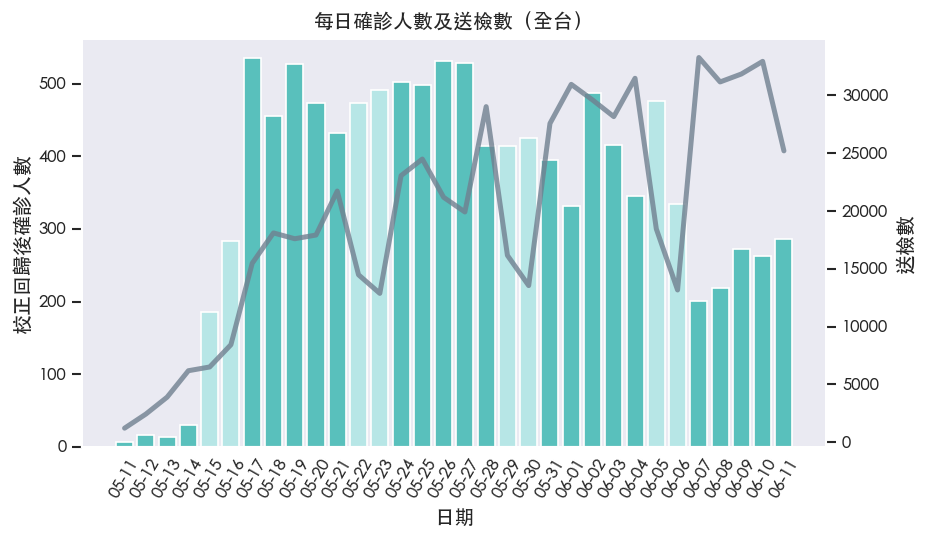

In [53]:
# Format the display of datetime in the x axis
combined["日期"] = combined["日期"].apply(lambda x: x.strftime("%m-%d"))

weekend_color = combined["週末"].map({True: "paleturquoise", False: "mediumturquoise"})

ax = sns.barplot(
    data=combined,
    x="日期",
    y="校正回歸後確診人數",
    palette=weekend_color,
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=60, va="center_baseline", ha="center")
ax.grid(False)

ax_twin = ax.twinx()
sns.lineplot(
    data=combined,
    x="日期",
    y="總送驗數",
    linewidth=3,
    color="slategray",
    alpha=0.8,
    ax=ax_twin,
)
ax_twin.grid(False)
ax_twin.set_ylabel("送檢數")

ax.set_title("每日確診人數及送檢數（全台）")

plt.show()

### Daily positive rate
Shift confirmation to 2 days before, which is divided by the total number of specimens.

In [54]:
# Shift confirmation to 2 days before
combined["當日送驗確診數"] = combined["校正回歸後確診人數"].shift(-2)

combined["送驗陽性率"] = combined["當日送驗確診數"] / combined["總送驗數"] * 100
combined["送驗陽性率（七天移動平均）"] = combined["送驗陽性率"].rolling(window=7).mean()

weekend_color = combined["週末"].map({True: "lightsteelblue", False: "cornflowerblue"})

### Plot the daily positive rate

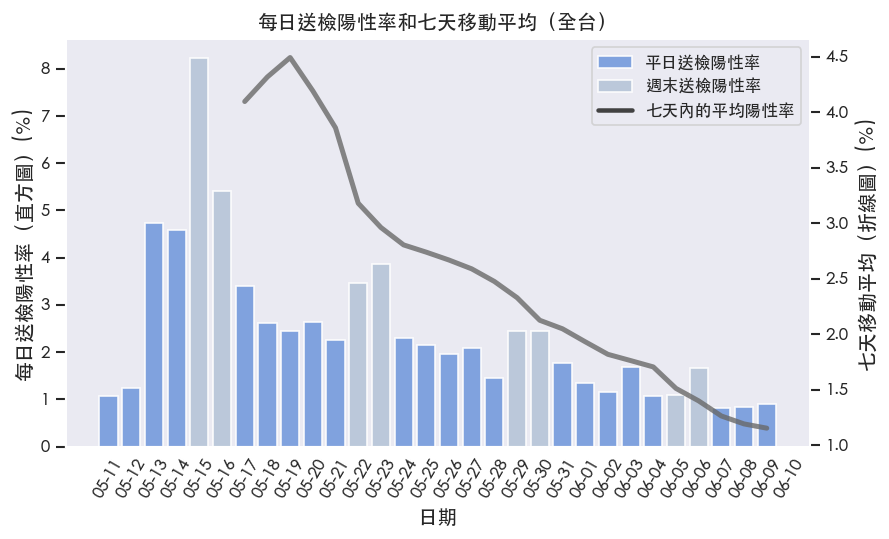

In [55]:
# Plotting configuration
mpl.rcParams["figure.figsize"] = [8, 4.5]
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["font.sans-serif"] = ["Heiti TC"]
mpl.rcParams["axes.titlesize"] = 12
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["xtick.labelsize"] = 10
mpl.rcParams["ytick.labelsize"] = 10
mpl.rcParams["xtick.labelsize"] = 10
mpl.rcParams["legend.fontsize"] = 10
mpl.rcParams["legend.handlelength"] = 2.0
mpl.rcParams["legend.handleheight"] = 0.7

# Plot the positive rate
ax = sns.barplot(data=combined, x="日期", y="送驗陽性率", palette=weekend_color, alpha=0.9)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, va="center_baseline", ha="center")
ax.grid(False)
fig = ax.get_figure()

# Create a right y-axis
ax_twin = ax.twinx()

# Plot 7-day moving average
sns.lineplot(
    data=combined,
    x="日期",
    y="送驗陽性率（七天移動平均）",
    linewidth=3,
    color="dimgray",
    alpha=0.8,
    ax=ax_twin,
)
ax_twin.grid(False)

ax.set_title("每日送檢陽性率和七天移動平均（全台）")
ax.set_ylabel("每日送檢陽性率（直方圖）(％)")
ax_twin.set_ylabel("七天移動平均（折線圖）(％)")

ax.legend(
    [ax.get_children()[0], ax.get_children()[4], ax.get_lines()[0]],
    ["平日送檢陽性率", "週末送檢陽性率", "七天內的平均陽性率"],
    loc=1,
)

plt.show()